# CNN with small datasets

> - Overcom overfitting:  
   **  (1) Data augmentation  
     (2) Doing feature extraction using a pre-trained model  
     (3) Fine-tuning a pre-trained model**  
> - Small Datasets: 4,000 images (2000 cats, 2000 dogs) (2000 for training, 1000 for validation, 1000 for test)  
> - Reference : Deep learning with python by F.Chollet

In [1]:
import numpy as np
import pandas as pd

import keras
import tensorflow as tf

Using TensorFlow backend.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
from IPython.display import display
import PIL

In [4]:
# How to check if the code is running on GPU or CPU?
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4800764240957379342
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 6814913823
locality {
  bus_id: 1
}
incarnation: 14858485129082007400
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


In [34]:
# Check if keras is using GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/gpu:0']

In [5]:
# (tf_gpu) C:\Users\admin>pip install --upgrade tensorflow keras numpy pandas sklearn pillow
from sklearn.preprocessing import LabelEncoder

### Preparation of datasets (dogs=1 vs. cats=0)

> download dataset from: https://www.kaggle.com/c/dogs-vs-cats/data  
> unzip it

In [6]:
import os, shutil

In [7]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = 'C:/Users/admin/Downloads/dogs-vs-cats/train/train'

# The directory where we will
# store our smaller dataset
base_dir = 'C:/Users/admin/Downloads/cats_and_dogs_small'

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [5]:
# make a path diroctory
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

os.mkdir(train_cats_dir)
os.mkdir(train_dogs_dir)
os.mkdir(validation_cats_dir)

os.mkdir(validation_dogs_dir)
os.mkdir(test_cats_dir)
os.mkdir(test_dogs_dir)

In [13]:
# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Check how many pictures are there in each training/validation/test split.  
* Balanced binary classification problem ==> 'accuracy' metric

In [8]:
print('total training cat images:', len(os.listdir(train_cats_dir)));
print('total training dog images:', len(os.listdir(train_dogs_dir)));
print('total validation cat images:', len(os.listdir(validation_cats_dir)));
print('total validation dog images:', len(os.listdir(validation_dogs_dir)));
print('total test cat images:', len(os.listdir(test_cats_dir)));
print('total test dog images:', len(os.listdir(test_dogs_dir)));

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


#### Image Preprocessing to floating point tensors of [0, 1] interval

- Read the picture files.
- Decode the JPEG content to RGB grids of pixcels.
- Convert these into floating point tensors.
- Rescale the pixel value (b/w 0 and 255) to the [0, 1] interval

In [9]:
# ImageDataGenerator class: allows to quickly set up Python generators 
# that can automatically turn image files on disk into batches of pre-processed tensors.
from keras.preprocessing.image import ImageDataGenerator

# rescaling by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # traget directory
    target_size=(150, 150), # resized to 150x150
    batch_size=20,
    class_mode='binary' # binary labels
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
n = 0
for data_batch, labels_batch in train_generator:
    n += 1
    print(n, 'data batch shape: ', data_batch.shape)
    print(n, 'labels batch shape: ', labels_batch.shape)
    print('--------------------------------------')
    
    if n == 5:
        break # without break train_generator iterates endlessly

1 data batch shape:  (20, 150, 150, 3)
1 labels batch shape:  (20,)
--------------------------------------
2 data batch shape:  (20, 150, 150, 3)
2 labels batch shape:  (20,)
--------------------------------------
3 data batch shape:  (20, 150, 150, 3)
3 labels batch shape:  (20,)
--------------------------------------
4 data batch shape:  (20, 150, 150, 3)
4 labels batch shape:  (20,)
--------------------------------------
5 data batch shape:  (20, 150, 150, 3)
5 labels batch shape:  (20,)
--------------------------------------


## 1. Training CNN from scratch as a baseline

In [19]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [21]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), 
             loss='binary_crossentropy', 
             metrics=['acc'])

In [22]:
hist = model.fit_generator(
    train_generator, 
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/50
100/100 [==============================] - 9s 86ms/step - loss: 0.6920 - acc: 0.5275 - val_loss: 0.6725 - val_acc: 0.6090
Epoch 2/50
100/100 [==============================] - 8s 78ms/step - loss: 0.6679 - acc: 0.5965 - val_loss: 0.6521 - val_acc: 0.5930
Epoch 3/50
100/100 [==============================] - 8s 79ms/step - loss: 0.6247 - acc: 0.6520 - val_loss: 0.6295 - val_acc: 0.6190
Epoch 4/50
100/100 [==============================] - 8s 78ms/step - loss: 0.5811 - acc: 0.7050 - val_loss: 0.6134 - val_acc: 0.6580
Epoch 5/50
100/100 [==============================] - 8s 78ms/step - loss: 0.5462 - acc: 0.7225 - val_loss: 0.6000 - val_acc: 0.6630
Epoch 6/50
100/100 [==============================] - 8s 78ms/step - loss: 0.5145 - acc: 0.7390 - val_loss: 0.5591 - val_acc: 0.6930
Epoch 7/50
100/100 [==============================] - 8s 77ms/step - loss: 0.4885 - acc: 0.7650 - val_loss: 0.5489 - val_acc: 0.7070
Epoch 8/50
100/100 [==============================] - 8s 78ms/step - 

In [17]:
# save a model above
model.save('cats_dogs_small_1.h5')

# model architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

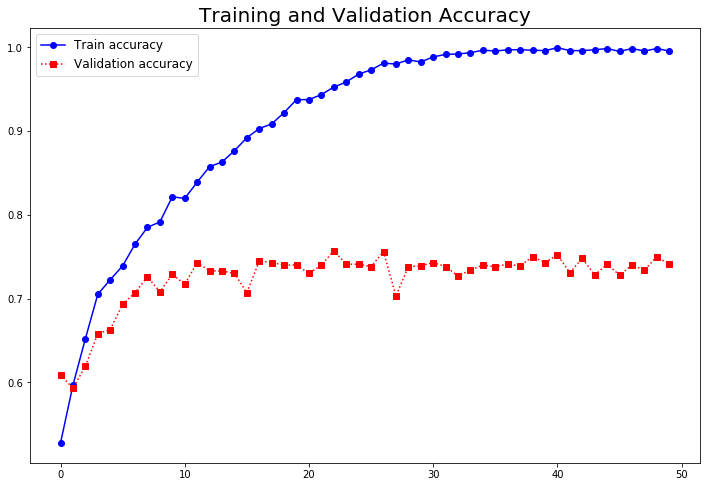

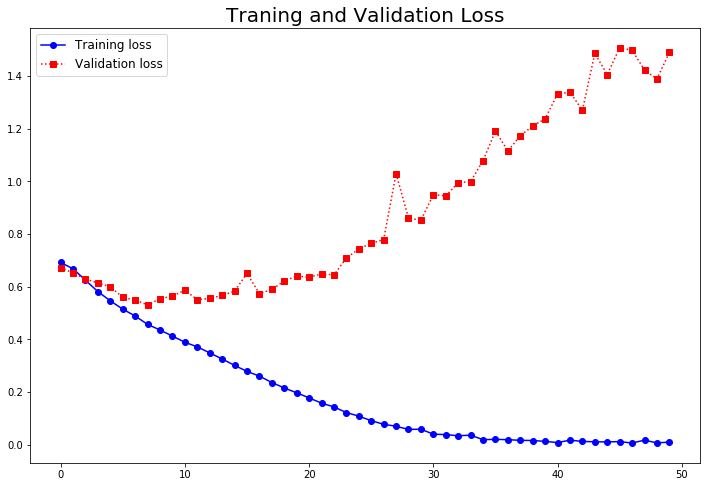

In [24]:
# plot of loss and accuracy of training & validation set
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', linestyle='-', label='Train accuracy')
plt.plot(epochs, val_acc, 'rs', linestyle=':', label='Validation accuracy')
plt.title('Training and Validation Accuracy', fontsize=20)
plt.legend(fontsize=12, loc='best')

plt.figure()

plt.plot(epochs, loss, 'bo', linestyle='-', label='Training loss')
plt.plot(epochs, val_loss, 'rs', linestyle=':', label='Validation loss')
plt.title("Traning and Validation Loss", fontsize=20)
plt.legend(fontsize=12, loc='best')

plt.show()

It sure seems like that this model with small dataset is overfitted. 

## 2. How to mitigate overfitting

### 2-1. Data augmentation

- Data augmentation generate samples via a number of random transformations
- In Keras, is's done by configuring a number of random transformations to be performed on the images read by ImageDataGenerator instance.

In [25]:
datagen = ImageDataGenerator(
    rotation_range=60, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest'
)

In [26]:
# samples of augmented images
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# pick one image to augment
img_path = fnames[5]

# read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# convert it to a numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

In [27]:
x.shape

(1, 150, 150, 3)

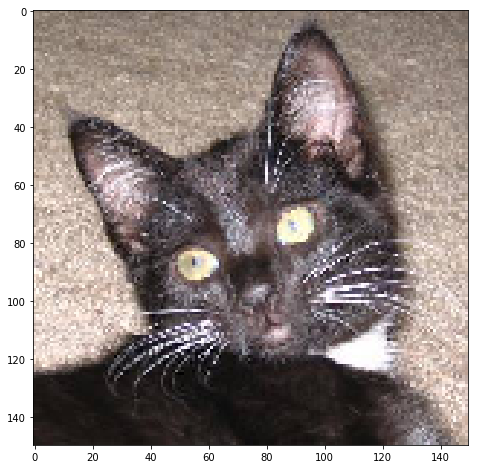

In [28]:
# original image
plt.imshow(image.array_to_img(x[0]))
plt.show()

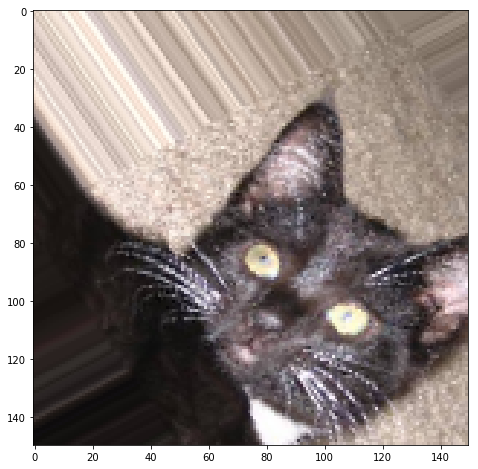

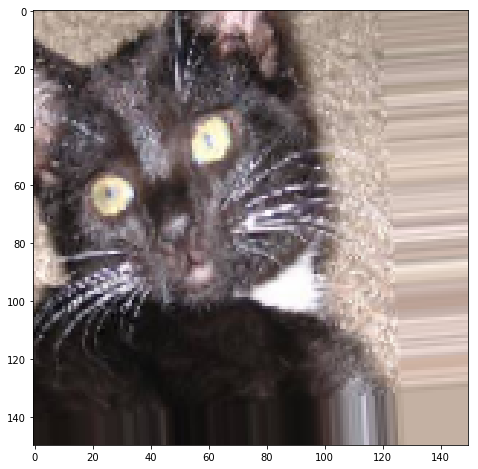

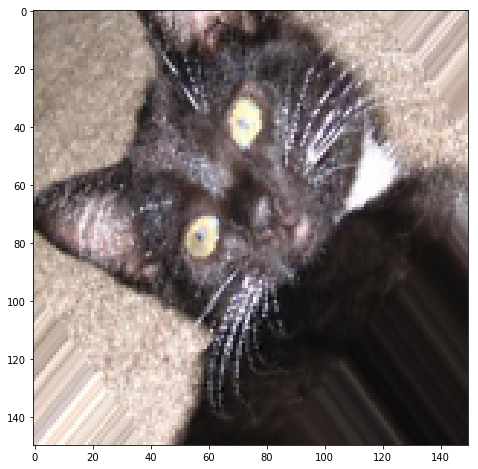

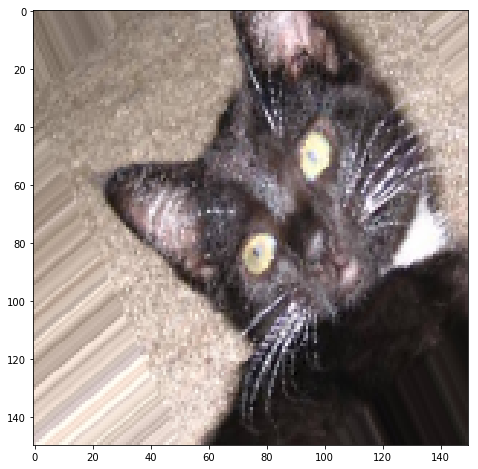

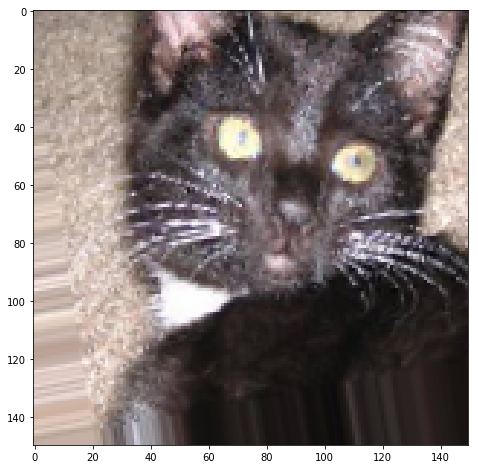

In [29]:
# generates batches of randomly transformed images
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 5:
        break
        
plt.show()

In [30]:
# build the convnet model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compile the convnet
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), 
             loss='binary_crossentropy', 
             metrics=['acc'])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [32]:
#-----
# Train the convnet using data augmentation and dropout
#-----

# train data is augmented
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=50,
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.3, 
    zoom_range=0.3, 
    horizontal_flip=True
)

# validation data is NOT augmented
valid_datagen = ImageDataGenerator(rescale=1./255)

# generator
train_generator = train_datagen.flow_from_directory(
    train_dir, # target directory
    target_size=(150, 150), # resized to 150x150
    batch_size=32,
    class_mode='binary'
)

validation_generator = valid_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
hist = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=100, 
    validation_data=validation_generator, 
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 24s 241ms/step - loss: 0.6936 - acc: 0.5172 - val_loss: 0.6809 - val_acc: 0.5812
Epoch 2/100
100/100 [==============================] - 22s 217ms/step - loss: 0.6812 - acc: 0.5625 - val_loss: 0.6890 - val_acc: 0.5296
Epoch 3/100
100/100 [==============================] - 22s 224ms/step - loss: 0.6695 - acc: 0.5744 - val_loss: 0.6596 - val_acc: 0.5787
Epoch 4/100
100/100 [==============================] - 23s 228ms/step - loss: 0.6617 - acc: 0.5900 - val_loss: 0.6517 - val_acc: 0.5909
Epoch 5/100
100/100 [==============================] - 22s 222ms/step - loss: 0.6491 - acc: 0.6094 - val_loss: 0.6173 - val_acc: 0.6307
Epoch 6/100
100/100 [==============================] - 24s 242ms/step - loss: 0.6364 - acc: 0.6272 - val_loss: 0.6201 - val_acc: 0.6334
Epoch 7/100
100/100 [==============================] - 21s 214ms/step - loss: 0.6351 - acc: 0.6350 - val_loss: 0.5917 - val_acc: 0.6783
Epoch 8/100
100/100 [===========================

In [35]:
# save a model above
model.save('cats_dogs_small_2.h5')

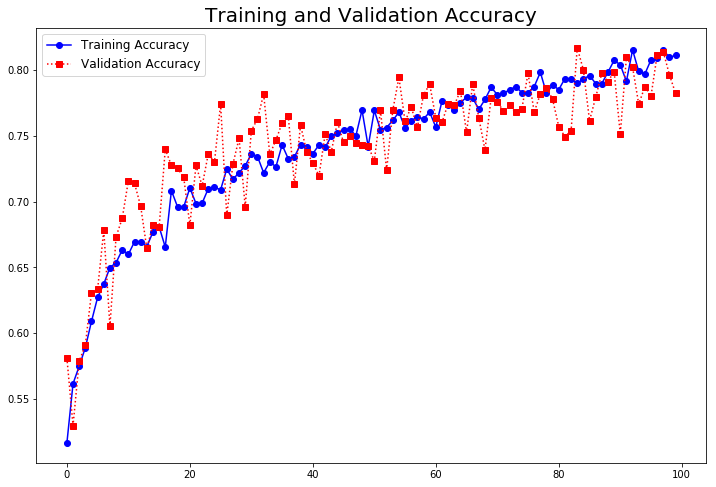

In [36]:
# plot the result of accuracy and loss
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

# accuracy
plt.plot(epochs, acc, 'bo', linestyle='-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'rs', linestyle=':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=20)
plt.legend(fontsize=12, loc='best')

plt.show()

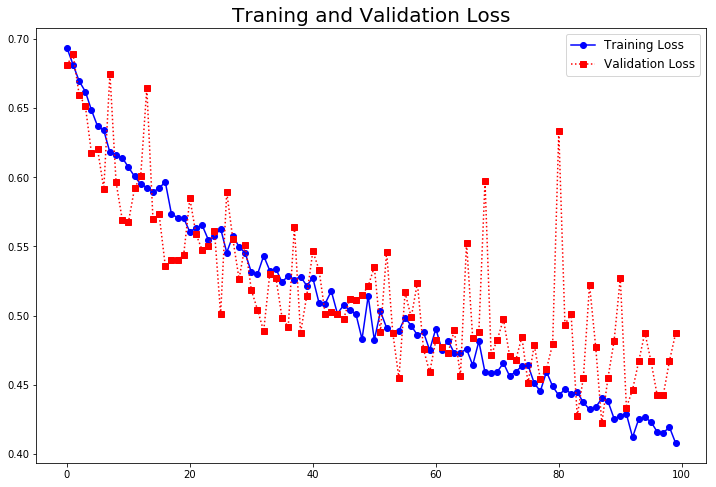

In [37]:
# loss
plt.plot(epochs, loss, 'bo', linestyle='-', label='Training Loss')
plt.plot(epochs, val_loss, 'rs', linestyle=':', label='Validation Loss')
plt.title('Traning and Validation Loss', fontsize=20)
plt.legend(fontsize=12, loc='best')

plt.show()